### **Data loading**

In [ ]:
# The data loading part is based on example https://www.kaggle.com/veb101/facial-expression-recognition-using-pytorch
!pip install -q torchsummary

from google.colab import files
import os

print("Upload your kaggle.json file containing your API keys")
if not os.path.exists(r"/content/fer2018.zip"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ashishpatel26/fer2018
!unzip -qq  fer2018.zip -d datasets/

Upload your kaggle.json file containing your API keys


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
 91% 88.0M/96.6M [00:03<00:00, 18.4MB/s]
100% 96.6M/96.6M [00:03<00:00, 32.5MB/s]


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
import math

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline  

In [ ]:
dataset = pd.read_csv('datasets/fer20131.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
dataset.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
# extracting pixel data from pixel column
# convert it to integer
# drop original pixel column
# add all pixels as individual column

pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

In [ ]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [ ]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

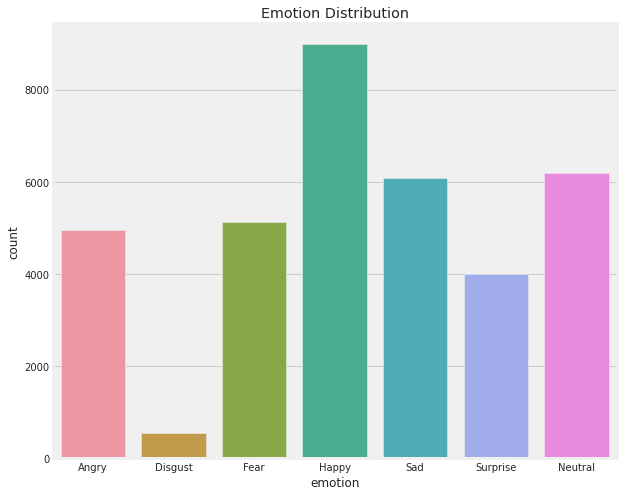

In [ ]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)], )


In [ ]:
def image_transformations() -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomCrop(48, padding=4, padding_mode='reflect'),     
        T.RandomRotation(15),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

In [ ]:
def get_train_dataset(dataframe: object, transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    return train_ds, val_ds

In [ ]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

def get_test_dataloader(dataframe: object, batch_size: int=64) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    return test_dl

In [ ]:
train_dl_un, valid_dl_un = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)
test_dl_un = get_test_dataloader(dataset)

images.shape: torch.Size([64, 1, 48, 48])


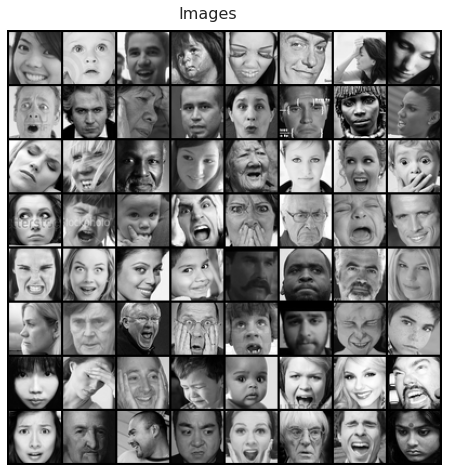

In [ ]:
for images, _ in train_dl_un:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

**ViT Tarining**

In [ ]:
pip install einops

In [ ]:
# The code is based on example https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data.float()), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data.float()), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [ ]:
import torch.optim as optim
N_EPOCHS = 50

model = ViT(image_size=48, patch_size=6, num_classes=7, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=256).float()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_dl_un, train_loss_history)
    evaluate(model, test_dl_un, test_loss_history)


Epoch: 1
[    0/32298 (  0%)]  Loss: 1.9858
[ 6400/32298 ( 20%)]  Loss: 1.8050
[12800/32298 ( 40%)]  Loss: 1.7942
[19200/32298 ( 59%)]  Loss: 1.7639
[25600/32298 ( 79%)]  Loss: 1.7249
[32000/32298 ( 99%)]  Loss: 1.8679

Average test loss: 1.7875  Accuracy:  902/ 3589 (25.13%)

Epoch: 2
[    0/32298 (  0%)]  Loss: 1.8119
[ 6400/32298 ( 20%)]  Loss: 1.7274
[12800/32298 ( 40%)]  Loss: 1.7687
[19200/32298 ( 59%)]  Loss: 1.8043
[25600/32298 ( 79%)]  Loss: 1.7118
[32000/32298 ( 99%)]  Loss: 1.5293

Average test loss: 1.6683  Accuracy: 1190/ 3589 (33.16%)

Epoch: 3
[    0/32298 (  0%)]  Loss: 1.6841
[ 6400/32298 ( 20%)]  Loss: 1.7129
[12800/32298 ( 40%)]  Loss: 1.5918
[19200/32298 ( 59%)]  Loss: 1.5299
[25600/32298 ( 79%)]  Loss: 1.5556
[32000/32298 ( 99%)]  Loss: 1.6731

Average test loss: 1.6054  Accuracy: 1319/ 3589 (36.75%)

Epoch: 4
[    0/32298 (  0%)]  Loss: 1.6234
[ 6400/32298 ( 20%)]  Loss: 1.6098
[12800/32298 ( 40%)]  Loss: 1.5597
[19200/32298 ( 59%)]  Loss: 1.6575
[25600/32298 ( 79